**Introduction**

In machine learning, binary linear classifiers can be utilized for multi-class classificiation in several ways. Two notable approaches include one-against-all and one-against-one. The goal of this homework is to implement multi-class classification using Rosenblatt's perceptrons (or like, see specifics below) using numpy and Tensorflow. 

**One-against-all**

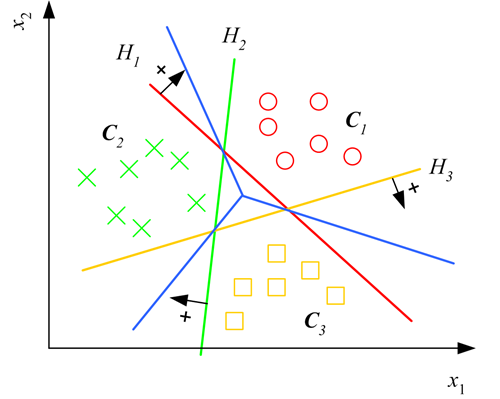

For K classes, this method requires K decision boundaries. Each boundary separates instances of class Ci from the rest of the data. A datapoint x is assigned to class Ci if the classification function $g_i(x)={max_{j=1}}^{K}(g_j(x))$ 


**One-against-one**

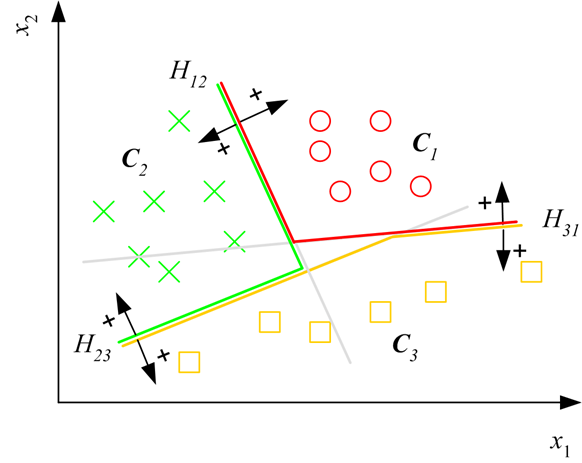

For K classes, this method requires K(K-1)/2 discriminants. Each boundary separates instances of class $C_i$ from class $C_j$, such that:

$g_{ij}(x) =
\begin{cases}
>0,\  if \ x\in C_i\\
≤0,\ if\ x\in C_j\\
\text{don't care otherwise}
\end{cases} $

A datapoint x is assigned to class $C_i$ if $∀ j != i, g_{ij}(x)>0$

**Dataset**

The code below generates the dataset to be used in this homework

/tmp/ipykernel_12157/2085528585.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  class3_samples = np.random.multivariate_normal(


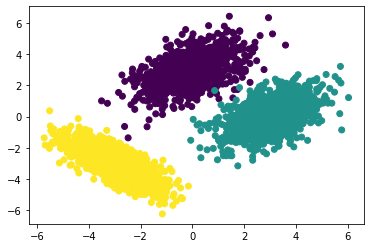

In [1]:
import numpy as np

num_samples_per_class = 1000
class1_samples = np.random.multivariate_normal(
mean=[0, 3],
cov=[[1, 0.5],[0.5, 1]],
size=num_samples_per_class)

class2_samples = np.random.multivariate_normal(
mean=[3, 0],
cov=[[1, 0.5],[0.5, 1]],
size=num_samples_per_class)

class3_samples = np.random.multivariate_normal(
mean=[-3, -3],
cov=[[-0.75, 1],[1,-0.75]],
size=num_samples_per_class)

#features
features = np.vstack((class1_samples, class2_samples, class3_samples)).astype(np.float32)

#labels
labels = np.vstack((np.ones((num_samples_per_class, 1), dtype="float32"), 
                    2*np.ones((num_samples_per_class, 1), dtype="float32"), 
                    3*np.ones((num_samples_per_class, 1), dtype="float32")))

import matplotlib.pyplot as plt
plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])
plt.show()


**Task 1**

Using the [numpy library](https://numpy.org/numpy-tutorials/), implement predict and train functions for Rosenblatt's perceptron with the hard limiter actication function as defined in the lecture. 

The predict function should take a feature matrix, a matrix of weights and return a vector of predicted variables.

The train function should take a feature matrix, a vector of labels and return a vector of weights of the trained model.

Verify that the training is working by training on a binary dataset of your own choosing and providing [measures of accuracy](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234). For example, you could use any of the two classes from the HW dataset. These should be separable with almost 100% accuracy.

#### Solution

In [2]:
from dataclasses import dataclass
from typing import (
    Union,
    Iterator,
    List,
    Any
)
import tensorflow as tf

In [3]:
@dataclass
class Perceptron:
    _weights: np.array = np.empty(1)
    alpha: float = .1
    high: int = 1
    low: int = -1
    train_iterations: int = 100

    def train(self, feat_matrix: np.array, label_vector: np.array, weights: Union[np.array, None] = None) -> np.array:
        weights = np.random.rand(1 + feat_matrix.shape[1]) if weights is None else weights
        self._set_binary_categories(label_vector)

        for _ in range(self.train_iterations):
            for data_point, label in zip(feat_matrix, label_vector):
                
                update = self.alpha * (label - self.predict(data_point, weights))
                weights[0] += update
                weights[1:] += update * data_point

        return weights
    
    def predict(self, feat_matrix: np.array, weights: np.array) -> np.array: 
        return self._hard_limiter(np.dot(feat_matrix, weights[1:]) + weights[0]) 

    def _hard_limiter(self, _net ) -> np.array:
        return np.where(_net >= 0, self.high, self.low)

    def _set_binary_categories(self, labels: np.array) -> None:
        res = list(np.unique(labels))
        res.sort()
        assert len(res) == 2
        self.low, self.high = res

    def model(self, feat_matrix, w, *args, **kwargs):
        return np.dot(feat_matrix, w[1:]) + w[0]

##### Training the perceptron

In [4]:
# Create Test Data with Two Classes
data = np.vstack((class1_samples, class2_samples)).astype(np.float32)
# Convert Test Labels to a More Friendly shape
test_labels = np.array([*([1] * num_samples_per_class), *([2] * num_samples_per_class)]).astype(np.float32)

In [5]:
# Split the Data into Training and Test
choice = np.random.choice(range(data.shape[0]), size=(int(data.shape[0] / 2),), replace=False)    
ind = np.zeros(data.shape[0], dtype=bool)
ind[choice] = True
rest = ~ind

train_data = data[ind]
train_labels = test_labels[ind]

test_data = data[rest]
test_labels = test_labels[rest]

In [6]:
p = Perceptron()

# training the perceptron
w = p.train(feat_matrix=train_data, label_vector=train_labels)

In [7]:
prediction = p.predict(test_data, w)

##### Calculating the Accuracy

In [8]:
def F1(prediction: np.array, truth: np.array, p: Perceptron) -> float:
    true_positives = sum((prediction == truth) * 1)
    false_positives = sum(((prediction == p.high) & (truth == p.low)) * 1)
    false_negatives = sum(((prediction == p.low) & (truth == p.high)) * 1)

    precision  = true_positives / (false_positives + true_positives)
    recall = true_positives / (false_negatives + true_positives)

    return 2 * (1 / ((1 / precision) + (1 / recall)))

In [9]:
def confusion_matrix(prediction: np.array, truth: np.array, p: Perceptron) -> float:
    true_positives = sum(((prediction == truth) & (truth == p.high)) * 1)
    true_negatives = sum(((prediction == truth) & (truth == p.low)) * 1)
    return (true_positives + true_negatives) / len(truth)

In [10]:
print(f"The F1 Score of the perceptron is {round(F1(prediction, test_labels, p) * 100, 3)}% ")

The F1 Score of the perceptron is 99.9% 


##### Plotting the Perceptron

In [11]:
x_range = np.array(range(-4, 6))
y_val = ((w[0] / w[2]) /  (w[0] / w[2])) * x_range + (w[0] / w[2]) 

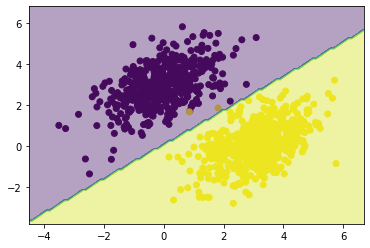

In [12]:
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels)

# Plotting decision regions
x_min, x_max = test_data[:, 0].min() - 1, test_data[:, 0].max() + 1
y_min, y_max = test_data[:, 1].min() - 1, test_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = p.predict(np.c_[xx.ravel(), yy.ravel()], w)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

**Task 2**

Using the perceptron functions defined above, implement predict/train functions for multi-class classifier.

The predict function should take a matrix of features, a matrix with weights of the perceptron classifiers and return a vector of labels. Use either one-against-all or one-against-one method when implemeting this function. Justify your method selection in the report.

The train function should take a matrix of features, a vector of labels and return the trained classification model (a matrix with perceptron weights). Here you need to utilize the perceptron train functions developed in Task 1.

Characterize the accuracy of the classifier using the [confusion matrix](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234).



#### Extending Task 1 to Support Multi Classification

In [13]:
@dataclass
class MultiPerceptron(Perceptron):
    _labels: tuple = ()

    def train(self, feat_matrix: np.array, label_vector: np.array) -> List[Any]:
        # create an empty weight holder
        weights = []
        # split and group the matrices
        for labels in self._split_data(feat_matrix, label_vector):
            w = np.random.rand(1 + feat_matrix.shape[1])
            w[0] = 0
            weights.append(super().train(feat_matrix, labels, w))
        return weights

    def _split_data(self, feat_matrix: np.array, label_vector: np.array) -> Iterator[np.array ]:
        # get the unique labels. 
        self._labels = tuple(np.unique(label_vector))

        # split the dataset into the correct number of training sets
        for l in self._labels:
            yield np.where(label_vector == l, 1, -1)

    
    def multipredict(self, feat_matrix: np.array, weights: list) -> np.array:
        # overload the predict function from above
        labels = np.vstack([[l] * feat_matrix.shape[0] for l in self._labels]).T
        prediction = np.zeros_like(labels)
        for i, w in enumerate(weights):
            prediction[:, i] = self.model(feat_matrix, w)
        return labels[0, np.argmax(prediction, 1)]


### Splitting Data into Test and Train 

In [14]:
data = features
labels = np.array([*([1] * num_samples_per_class), *([2] * num_samples_per_class), *([3] * num_samples_per_class)]).astype(np.float32)

In [15]:
# Split the Data into Training and Test
choice = np.random.choice(range(data.shape[0]), size=(int(data.shape[0] / 2),), replace=False)    
ind = np.zeros(data.shape[0], dtype=bool)
ind[choice] = True
rest = ~ind

train_data = data[ind]
train_labels = labels[ind]

test_data = data[rest]
test_labels = labels[rest]

In [16]:
p = MultiPerceptron()

# training the perceptron
w = p.train(feat_matrix=train_data, label_vector=train_labels)

In [17]:
prediction = p.multipredict(test_data, w)

In [18]:
for l in p._labels:
    p.high = l
    p.low = -1
    prediction_local = np.where(prediction == l, l, -1)
    labels_local = np.where(test_labels == l, l, -1)
    print(f"The Confusion Matrix Score of the perceptron for category {l} is {round(confusion_matrix(prediction_local, labels_local, p) * 100, 3)}% ")

The Confusion Matrix Score of the perceptron for category 1.0 is 99.533% 
The Confusion Matrix Score of the perceptron for category 2.0 is 99.6% 
The Confusion Matrix Score of the perceptron for category 3.0 is 99.533% 


#### Plotting the Results

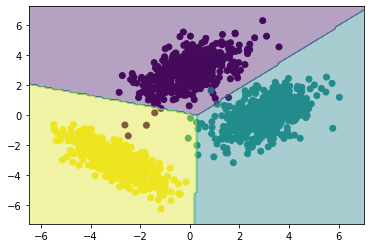

In [19]:
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels)

# Plotting decision regions
x_min, x_max = test_data[:, 0].min() - 1, test_data[:, 0].max() + 1
y_min, y_max = test_data[:, 1].min() - 1, test_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = p.multipredict(np.c_[xx.ravel(), yy.ravel()], w)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)

plt.show()

**Task 3**

Implement the same multi-class classfier using [Tensorflow's GradientTape](https://www.tensorflow.org/guide/autodiff) in the training functions (also see examples in Chapter 3 of the textbook).

Notes:
- a hard limiter function is not the best choice here. Use sigmoid or other activation function.
- Keep the functions implemented in the Task 2 the same and redefine the train/predict functions implemened in Task 1
- You could implement a different approach and train all neurons at once



In [20]:
import tensorflow as tf

In [21]:
@dataclass
class TFPerceptron(Perceptron):
    W: tf.Variable = None
    b: tf.Variable = None
    train_iterations: int = 1000
    
    def train(self, feat_matrix: np.array, label_vector: np.array, weights: Union[np.array, None] = None) -> np.array:
        W = tf.Variable(initial_value=tf.random.uniform(shape=(feat_matrix.shape[1], 1))) 
        b = tf.Variable(initial_value=tf.zeros(shape=(feat_matrix.shape[1],)))
        for _ in range(self.train_iterations):
            _, W, b = self.training_step(feat_matrix, label_vector, W, b)
        return (W, b)

    def square_loss(self, targets, predictions):
        per_sample_losses = tf.square(targets - predictions) 
        return tf.reduce_mean(per_sample_losses)

    def model(self, inputs: np.array, W, *args, **kwargs) -> np.array:
        return tf.nn.relu(tf.add(tf.matmul(inputs, W[0]), W[1]))[:, 0]

    def training_step(self, inputs, targets, W, b):
        with tf.GradientTape() as tape: 
            predictions = self.model(inputs, (W, b))
            loss = self.square_loss(predictions, targets)
        grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
        W.assign_sub(grad_loss_wrt_W * self.alpha) 
        b.assign_sub(grad_loss_wrt_b * self.alpha) 
        return loss, W, b
        

In [22]:
class TFMultiPerceptron(MultiPerceptron, TFPerceptron):

  def __init__(self, *args, **kwargs):
    super().__init__(self, *args, **kwargs)

In [23]:
# using the test and train data from above
p = TFMultiPerceptron(train_iterations=1000, alpha=0.1)

# training the perceptron
w = p.train(feat_matrix=train_data, label_vector=train_labels)


2022-01-27 11:02:05.178241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/share/lib
2022-01-27 11:02:05.178309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/share/lib
2022-01-27 11:02:05.178355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/share/lib
2022-01-27 11:02:05.178397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Cou

In [24]:
prediction = p.multipredict(test_data, w)

In [25]:
for l in p._labels:
    p.high = l
    p.low = -1
    prediction_local = np.where(prediction == l, l, -1)
    labels_local = np.where(test_labels == l, l, -1)
    print(f"The Confusion Matrix Score of the perceptron for category {l} is {round(confusion_matrix(prediction_local, labels_local, p) * 100, 3)}% ")

The Confusion Matrix Score of the perceptron for category 1.0 is 99.533% 
The Confusion Matrix Score of the perceptron for category 2.0 is 99.667% 
The Confusion Matrix Score of the perceptron for category 3.0 is 99.733% 


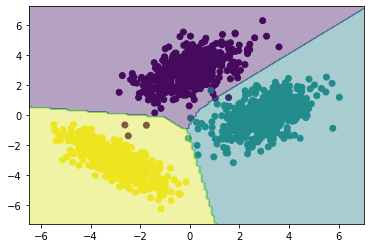

In [26]:
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels)

# Plotting decision regions
x_min, x_max = test_data[:, 0].min() - 1, test_data[:, 0].max() + 1
y_min, y_max = test_data[:, 1].min() - 1, test_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = p.multipredict(np.c_[xx.astype(np.float32).ravel(), yy.astype(np.float32).ravel()], w)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)

plt.show()

**Grading**

- (10 pts) Report quality / submission requirement followed (see class policy)
- (30 pts) Task 1
- (30 pts) Task 2
- (30 pts) Task 3

**Report** (your report goes here, keep the length manageable)
Report may also be submitted as a pdf document in the same compressed folder.

- Introduction
- Methods
- Results
- Discussion/Conclusions

## Report

Author:: Max Schrader

### Introduction

This homework assignment called for a 

**Submission**

Using Blackboard, submit the .ipynb file in a compressed folder as defined by the class policy.